In [48]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib import rcParams
import sympy as sy
import scipy.constants as pc
from sympy import *
from math import log10, floor

rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [49]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)
            
    
def txtToArr(name):
    with open(name) as f:
        l = f.readlines()
    
    del l[0]

    time_arr = np.array([])
    temp_arr = np.array([])

    for el in l:
        el_changed = l[l.index(el)].replace(',', '.') 
        l[l.index(el)] = el_changed.split()
        el_changed = el_changed.split()
        time_arr = np.append(time_arr, float(el_changed[0]))
        temp_arr = np.append(temp_arr, float(el_changed[1]))
    
    return time_arr, temp_arr

In [ ]:
# Standard plotting

fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, fmt='D', color='#d0740b', label='label')

ax.set(xlabel='x', ylabel='y', title='Titel')
ax.legend()
ax.grid()

#fig.savefig("test.png")

In [ ]:
# Erinnerungen
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

103.74098360655738
0.16488739408384545
-17.93387096774193
0.07668238381297279
t [ 0.8  2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
 57.  58.  59.  60.  61.  62. ]
$T_W$ [102.1 103.6 103.4 103.3 103.6  97.3 103.6 103.6 103.5 103.7 103.1 103.2
 103.4 103.4 103.1 103.5 103.9 104.  104.9 104.  104.1 103.8 104.  103.9
 103.7 104.3 104.3 104.6 104.2 104.4 104.2 104.1 104.1 104.  104.3 103.6
 103.9 103.9 103.7 103.6  97.7 104.2 103.3 103.9 104.2 103.6 103.9 103.8
 104.2 104.2 103.9 105.3 105.6 105.1 104.4 105.1 104.1 104.5 103.9 104.2
 104.2]
$T_E$ [-19.1 -18.9 -18.3 -18.8 -19.3 -18.9 -19.3 -18.4 -18.1 -18.9 -18.4 -18.4
 -18.3 -18.1 -18.4 -17.9 -18.  -18.1 -18.5 -17.9 -18.  -18.1 -17.5 -18.
 -18.  -17.3 -17.4 -18.2 -17.6 -17.8 -18.3 -18.2 -18.  -18.2 -17.8 -18.1
 -18.

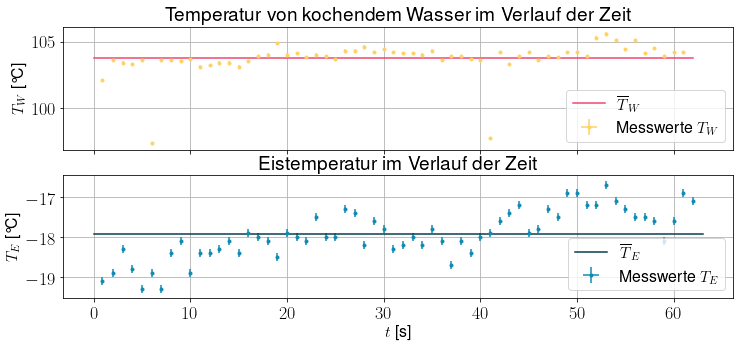

In [161]:
# KALIBRIERDATEN
temp_f = 0.1
time_f = 0.01

time_w_k, temp_w_k  = txtToArr('kochend.txt')
time_e_k, temp_e_k  = txtToArr('Eis.txt')


fig, (ax0, ax1) = plt.subplots(2, figsize=(12,5), sharex=True) 
ax0.tick_params(axis='both', which='major', labelsize=18)
ax0.tick_params(axis='both', which='minor', labelsize=16)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=16)

ax0.errorbar(time_w_k, temp_w_k, xerr=time_f, yerr=temp_f, fmt='.', color='#ffd166', label=r'Messwerte $T_W$')

x_w = np.linspace(0, max(time_w_k)+1, 100)
y_w = np.full( shape=100, fill_value=am(temp_w_k))
ax0.plot(x_w, y_w, color='#ef476f', label='$\overline{T}_W$')


ax0.set(xlabel=r'', ylabel=r'$T_W$ [°C]', title=r'Temperatur von kochendem Wasser im Verlauf der Zeit')
ax0.legend()
ax0.grid()

ax1.errorbar(time_e_k, temp_e_k, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label=r'Messwerte $T_E$')

x_e = np.linspace(0, max(time_e_k)+1, 100)
y_e = np.full( shape=100, fill_value=am(temp_e_k))
ax1.plot(x_e, y_e, color='#073b4c', label='$\overline{T}_E$')


ax1.set(xlabel=r'$t$ [s]', ylabel=r'$T_E$ [°C]', title=r'Eistemperatur im Verlauf der Zeit')
ax1.legend()
ax1.grid()

fig.savefig("kal.svg")

print(am(temp_w_k))
print(stu(temp_w_k))
print(am(temp_e_k))
print(stu(temp_e_k))

print(r't', time_e_k)
print(r'$T_W$', temp_w_k)
print(r'$T_E$',temp_e_k)

Kaltes Wasser Temperatur 26.830392156862743
Kaltes Wasser Temperatur STU 0.04603876076830793


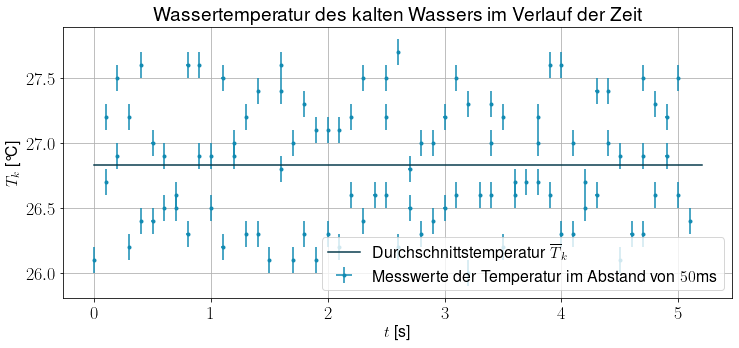

In [164]:
time_w_2, temp_w_2  = txtToArr('6.2_Wasser1_2.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_w_2, temp_w_2, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')

x_2 = np.linspace(0, max(time_w_2)+0.1, 100)
y_2 = np.full( shape=100, fill_value=am(temp_w_2))
ax.plot(x_2, y_2, color='#073b4c', label='Durchschnittstemperatur $\overline{T}_k$')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T_k$ [°C]', title=r'Wassertemperatur des kalten Wassers im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Wasser_temp_2.svg")

print('Kaltes Wasser Temperatur', am(temp_w_2))
print('Kaltes Wasser Temperatur STU', stu(temp_w_2))

Heißes Wasser Temperatur 96.27999999999999
Heißes Wasser Temperatur STU 0.03552741748176538


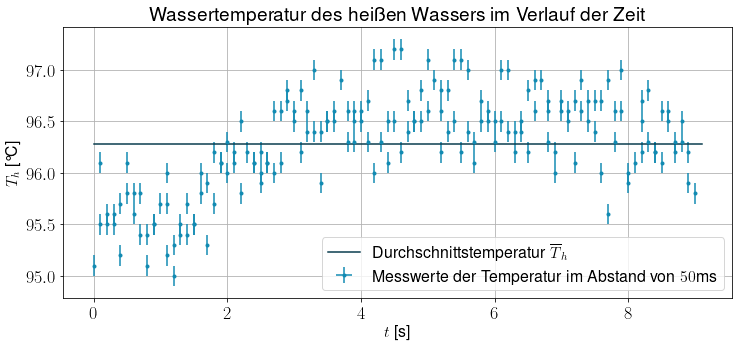

In [163]:
time_w_4, temp_w_4  = txtToArr('6.2_Wasser2_2.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_w_4, temp_w_4, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')

x_4 = np.linspace(0, max(time_w_4)+0.1, 100)
y_4 = np.full( shape=100, fill_value=am(temp_w_4))
ax.plot(x_4, y_4, color='#073b4c', label='Durchschnittstemperatur $\overline{T}_h$')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T_h$ [°C]', title=r'Wassertemperatur des heißen Wassers im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Wasser_temp_4.svg")

print('Heißes Wasser Temperatur', am(temp_w_4))
print('Heißes Wasser Temperatur STU', stu(temp_w_4))

Temperatur vor Mischen 27.570930232558137
Temperatur vor Mischen stu 0.03690733317817675
115
Temperatur nach Mischen 53.32571428571429
Temperatur nach Mischen stu 0.06506674120050636


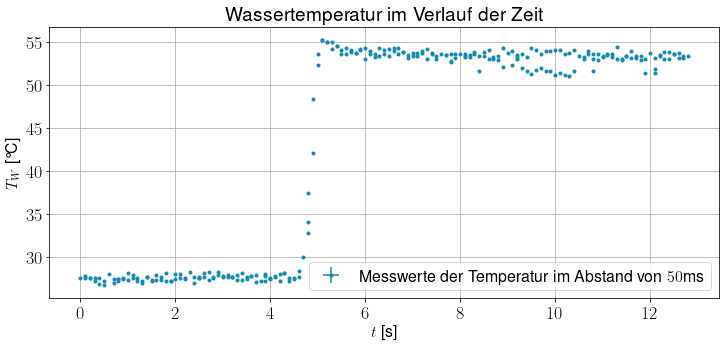

In [165]:
time_er_2, temp_er_2  = txtToArr('6.2_Ergebnis_2.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_er_2, temp_er_2, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')


limit_v1 = np.amax(np.where(temp_er_2 == temp_er_2[np.where(time_er_2 == 4.3)][1]))
temp_to_limit_v1 = np.array([])
time_to_limit_v1 = np.array([])

for i in range(int(limit_v1)):
    temp_to_limit_v1 = np.append(temp_to_limit_v1, temp_er_2[i])

print('Temperatur vor Mischen', am(temp_to_limit_v1))
print('Temperatur vor Mischen stu', stu(temp_to_limit_v1))

limit_v2 = np.amin(np.where(temp_er_2 == temp_er_2[np.where(time_er_2 == 5.8)][1]))
print(limit_v2)
temp_from_limit_v2 = np.array([])


for i in range(int(limit_v2), int(np.where(time_er_2 == np.amax(time_er_2))[0])):
    temp_from_limit_v2 = np.append(temp_from_limit_v2, temp_er_2[i])
    
print('Temperatur nach Mischen', am(temp_from_limit_v2))
print('Temperatur nach Mischen stu', stu(temp_from_limit_v2))

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Erg_temp_w.svg")

Temperatur vor Mischen 47.7395
Temperatur vor Mischen stu 0.04708538966174104
Temperatur nach Mischen 22.395522388059703
Temperatur nach Mischen stu 0.016593696071749802


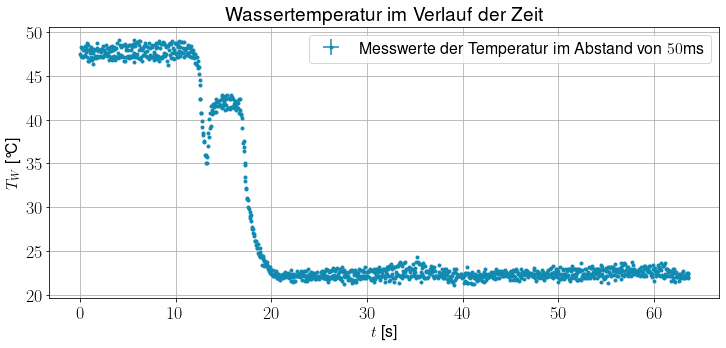

In [157]:
time_er_63, temp_er_63  = txtToArr('6.3_Ergebnis.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_er_63, temp_er_63, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')

limit_1 = np.amax(np.where(temp_er_63 == temp_er_63[np.where(time_er_63 == 10)][1]))
temp_to_limit_1 = np.array([])
time_to_limit_1 = np.array([])


for i in range(int(limit_1)):
    temp_to_limit_1 = np.append(temp_to_limit_1, temp_er_63[i])

print('Temperatur vor Mischen', am(temp_to_limit_1))
print('Temperatur vor Mischen stu', stu(temp_to_limit_1))

limit_2 = np.amin(np.where(temp_er_63 == temp_er_63[np.where(time_er_63 == 20)][1]))
temp_from_limit_2 = np.array([])


for i in range(int(limit_2), int(np.where(time_er_63 == np.amax(time_er_63))[0])):
    temp_from_limit_2 = np.append(temp_from_limit_2, temp_er_63[i])
    
print('Temperatur nach Mischen', am(temp_from_limit_2))
print('Temperatur nach Mischen stu', stu(temp_from_limit_2))


ax.set(xlabel=r'$t$ [s]', ylabel=r'$T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Erg_temp_63.svg")

Temperatur des Eis 4.334158415841584
Temperatur des Eis stu 0.023818470030062884


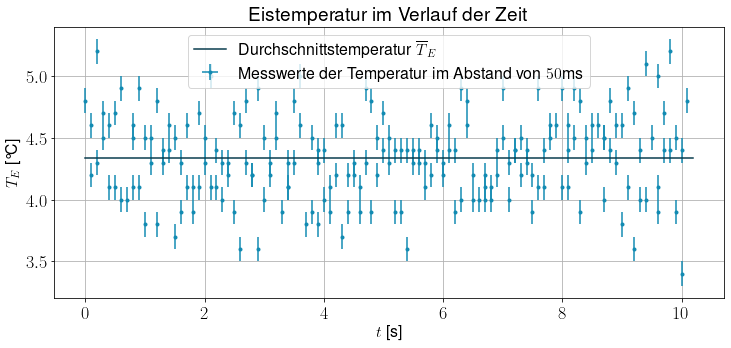

In [156]:
time_e_63, temp_e_63  = txtToArr('6.3_Eis.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_e_63, temp_e_63, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')

x_e = np.linspace(0, max(time_e_63)+0.1, 100)
y_e = np.full( shape=100, fill_value=am(temp_e_63))
ax.plot(x_e, y_e, color='#073b4c', label='Durchschnittstemperatur $\overline{T}_E$')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T_E$ [°C]', title=r'Eistemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

print('Temperatur des Eis', am(temp_e_63))
print('Temperatur des Eis stu', stu(temp_e_63))



fig.savefig("Eis_temp_63.svg")